<a href="https://colab.research.google.com/github/CelestineNguyen/DS3001_SalesProject/blob/main/factor_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/CelestineNguyen/DS3001_SalesProject.git

Cloning into 'DS3001_SalesProject'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 84 (delta 33), reused 48 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (84/84), 1.53 MiB | 5.49 MiB/s, done.
Resolving deltas: 100% (33/33), done.
Filtering content: 100% (8/8), 333.14 MiB | 28.22 MiB/s, done.


In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('/content/DS3001_SalesProject/clean_data/all_ex_holidays.csv', low_memory=False)
print(df.shape)
print(df.head)

(3000888, 12)
<bound method NDFrame.head of               id        date  store_nbr                      family     sales  \
0              0  2013-01-01          1                  AUTOMOTIVE     0.000   
1              1  2013-01-01          1                   BABY CARE     0.000   
2              2  2013-01-01          1                      BEAUTY     0.000   
3              3  2013-01-01          1                   BEVERAGES     0.000   
4              4  2013-01-01          1                       BOOKS     0.000   
...          ...         ...        ...                         ...       ...   
3000883  3000883  2017-08-15          9                     POULTRY   438.133   
3000884  3000884  2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885  2017-08-15          9                     PRODUCE  2419.729   
3000886  3000886  2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887  2017-08-15          9                     SEAFO

In [4]:
# Check missing values
print(df.isnull().sum())

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
transactions         0
dcoilwtico      928422
city                 0
state                0
type                 0
cluster              0
dtype: int64


In [5]:
# Fill missing oil prices
df['dcoilwtico'] = df['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')

# Verify there are no more missing values
print(df.isnull().sum())

<ipython-input-5-b97350ab6e6a>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['dcoilwtico'] = df['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')


id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
transactions    0
dcoilwtico      0
city            0
state           0
type            0
cluster         0
dtype: int64


In [6]:
# One-hot encode family, type, and cluster
df = pd.get_dummies(df, columns=['family', 'type', 'cluster'], drop_first=True)

In [7]:
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Extract year, month, and day of the week
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek

In [8]:
from sklearn.preprocessing import StandardScaler
# Used chatGPT for help in some sections

# Select numerical columns to scale
numerical_features = ['transactions', 'onpromotion', 'dcoilwtico', 'year', 'month', 'day_of_week']
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

X = df.drop(['id', 'sales'], axis=1)
y = df['sales']

In [9]:
from sklearn.model_selection import train_test_split

# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [10]:
print(X_train.dtypes)
X_train = X_train.drop(['date'], axis=1, errors='ignore')
X_test = X_test.drop(['date'], axis=1, errors='ignore')

date            datetime64[ns]
store_nbr                int64
onpromotion            float64
transactions           float64
dcoilwtico             float64
                     ...      
cluster_16                bool
cluster_17                bool
year                   float64
month                  float64
day_of_week            float64
Length: 62, dtype: object


In [11]:
# One-hot encoding to categorical columns
X_train = pd.get_dummies(X_train, columns=['city', 'state'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['city', 'state'], drop_first=True)

X_train, X_test = X_train.align(X_test, join='left', axis=1)
X_test = X_test.fillna(0)

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"R² Score: {r2}")
print(f"RMSE: {rmse}")


R² Score: 0.6180420266491968
RMSE: 841.3941328155479


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [13]:
mean_sales = y_test.mean()
print(f"Mean Sales: {mean_sales}")

Mean Sales: 475.9209068881851


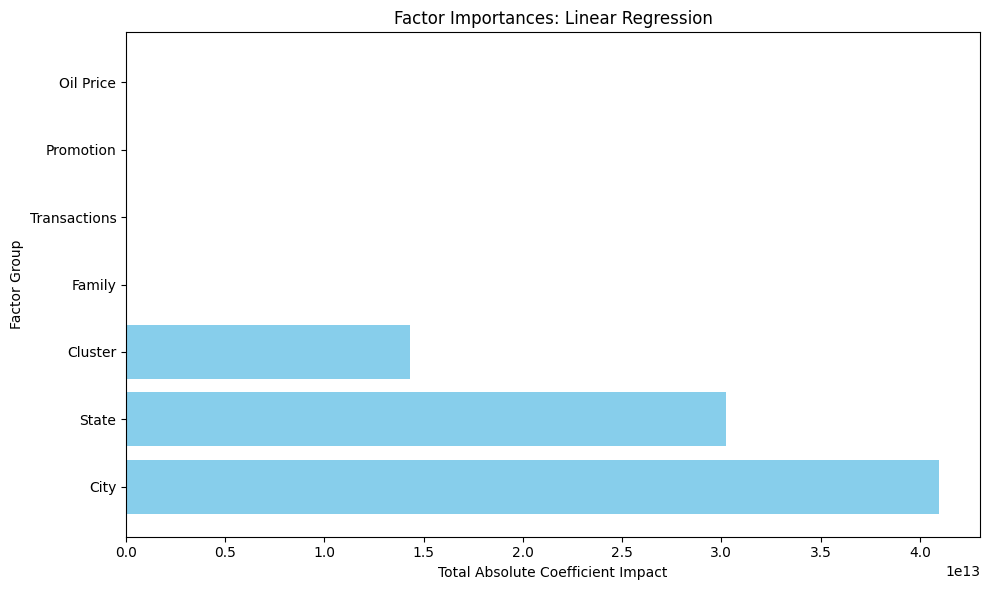

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Get coefficients and feature names
coefficients = model.coef_
feature_names = X_train.columns

# Combine feature names and coefficients into a DataFrame
coef_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})

# Identify groups for aggregation
groups = {
    'Family': coef_df[coef_df['feature'].str.startswith('family')]['coefficient'].abs().sum(),
    'City': coef_df[coef_df['feature'].str.startswith('city')]['coefficient'].abs().sum(),
    'Cluster': coef_df[coef_df['feature'].str.startswith('cluster')]['coefficient'].abs().sum(),
    'State': coef_df[coef_df['feature'].str.startswith('state')]['coefficient'].abs().sum(),
    'Promotion': coef_df[coef_df['feature'].str.startswith('onpromotion')]['coefficient'].abs().sum(),
    'Transactions': coef_df[coef_df['feature'] == 'transactions']['coefficient'].abs().sum(),
    'Oil Price': coef_df[coef_df['feature'] == 'dcoilwtico']['coefficient'].abs().sum()
}

# Convert group dictionary to DataFrame
group_df = pd.DataFrame(list(groups.items()), columns=['Factor Group', 'Total Impact'])

# Sort by impact
group_df = group_df.sort_values(by='Total Impact', ascending=False)

# Plot the grouped feature importances
plt.figure(figsize=(10, 6))
plt.barh(group_df['Factor Group'], group_df['Total Impact'], color='skyblue')
plt.title('Factor Importances: Linear Regression')
plt.xlabel('Total Absolute Coefficient Impact')
plt.ylabel('Factor Group')
plt.tight_layout()
plt.show()



In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the KNN regressor
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled)

r2_knn = r2_score(y_test, y_pred_knn)
rmse_knn = mean_squared_error(y_test, y_pred_knn, squared=False)

print(f"KNN R² Score: {r2_knn}")
print(f"KNN RMSE: {rmse_knn}")
